In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

np.random.seed(23)

In [2]:
df = pd.read_csv('../data/survey_data_before_pre_processing.csv')

### Convert all Nulls to 'none'
- This is done prior to ordinal encoding 

In [3]:
df.fillna('none', inplace=True)

### Ordinal Encode

In [4]:
# Ordinal encoding these features

# the list of columns to ordinal
df_ord = df[['year','wave', 'cause_recoded', 'sci_consensus',
             'harm_personally', 'harm_US', 'harm_dev_countries',
             'harm_future_gen', 'harm_plants_animals', 'when_harm_US', 
             'generation', 'educ_category', 'income_category',
             'reg_CO2_pollutant', 'fund_research', 
             'discuss_GW']]

# have first spot be 'none' for features that got nulls changed
# have first spot be '' for features with no nulls changed
# this allows us to peel off nulls by removing all 0 encoded ordinals
dogs = [[-999,2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
        ['','2008 Nov', '2010 Jan', '2010 Jun', '2011 May', '2011 Nov', 
         '2012 Mar', '2012 Sep', '2013 Apr', '2013 Nov', '2014 Apr',
         '2014 Oct', '2015 Mar', '2015 Oct', '2016 Mar', '2016 Nov',
         '2017 May', '2017 Oct', '2018 Mar', '2018 Dec',],
# cause_rec
        ['none', 'No', "Don't know", 'Yes'],
# sci_cons
        ['none', 'No', "Don't know", 'Maybe', 'Yes'],

        ['none','No',"Don't know", 'Yes'],
        ['none','No',"Don't know", 'Yes'],
        ['none','No',"Don't know", 'Yes'],
        ['none','No',"Don't know", 'Yes'],
        ['none','No',"Don't know", 'Yes'],
        ['none','Never', 'In the Future', 'Now'],
# gen
        ['','Greatest (Before 1928)','Silent (1928 - 1945)',
         'Baby Boomers (1946 - 1964)',
         'Generation X (1965 - 1980)',
         'Millennials (1981 - 1996)',
         'iGen\u200e/Gen Z (1997 - )'],
# ed
        ['','Less than high school',
         'High school',
         'Some college',
         'Bachelor\'s degree or higher'],
# income        
        ['','Less than $50,000',
         '$50,000 to $99,999',
         '$100,000 or more'],
        
        ['none','Oppose', 'Support'],
        ['none','Oppose', 'Support'],
        ['none','Never', 'At All']]


# initialize
o_enc = OrdinalEncoder(categories=dogs) 

# fit transform
X_ord = o_enc.fit_transform(df_ord)

# add to df
# col names are original names + '_ord'
X_ord_df = pd.DataFrame(X_ord,
                        columns = [col+'_ord' for col in df_ord.columns])\
                .applymap(lambda x: np.nan if x == 0 else x)

# drop non-ordinal cols for ordinal cols
df = df.drop(df_ord.columns, axis = 1).join(X_ord_df)

### Dummy encoding remaining features and adding features that were already ordinal encoded

In [5]:
dum_df = df[['party', 'party_x_ideo', 'region4', 
             'religion','marit_status', 'employment', 'house_head',
             'house_type', 'house_own']]

rdy_to_go = df[['house_ages18plus', 'children', 'service_attendance', 'house_size']]


In [6]:
dum_df = pd.get_dummies(dum_df, drop_first=True)

In [7]:
additional_df = pd.concat([dum_df, rdy_to_go],  axis=1)

In [8]:
df.drop(['party', 'party_x_ideo', 'region4', 
         'religion','marit_status', 'employment', 'house_head',
         'house_type', 'house_own','house_ages18plus',
         'children', 'service_attendance', 'house_size'], axis=1, inplace=True)

In [9]:
df = pd.concat([df, additional_df], axis=1)

### Label Encoding target

In [10]:
df['happening'] = [0 if x == 'No' 
                   else 1 if x == "Don't know" 
                   else 2 for x in df.happening]

### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
y = df.happening
X = df[[cols for cols in df.columns if cols != "happening"]]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size = 0.20,
                                                   random_state = 21)

### Iteratively Impute Nulls

Now all of our data is ordinal encoded or dummied, iteratively impute the nulls

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [15]:
# identify numerical columns
cols = X_train.describe().columns

In [16]:
# identify columns that will have nulls imputed
cols_with_indicator = X_train[cols].loc[:,X_train[cols].isnull().any()].columns

# rename them
cols_with_indicator = [c+'_ind' for c in cols_with_indicator]

In [17]:
# initialize
it_imp = IterativeImputer(initial_strategy='mean',
                              add_indicator=True,
                              random_state = 21
                             )

In [18]:
# fit on train
X_train_it_imp = pd.DataFrame(it_imp.fit_transform(X_train[cols]),
                columns = X_train[cols].columns.to_list()+cols_with_indicator,
                index = X_train.index)

# transform test
X_test_it_imp = pd.DataFrame(it_imp.transform(X_test[cols]),
            columns = X_train[cols].columns.to_list()+cols_with_indicator,
            index = X_test.index)

In [19]:
X_train = X_train.drop(cols, axis = 1).join(X_train_it_imp)
X_test = X_test.drop(cols, axis = 1).join(X_test_it_imp)

### Standard Scale

Will let us explore knn or clustering if wanted

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = pd.DataFrame(ss.fit_transform(X_train[cols]),
                          columns = X_train[cols].columns,
                          index = X_train.index)

# transform test
X_test_ss = pd.DataFrame(ss.transform(X_test[cols]),
                         columns = X_test[cols].columns,
                         index = X_test.index)

In [22]:
X_train_ss = X_train.drop(cols, axis = 1).join(X_train_ss)
X_test_ss = X_test.drop(cols, axis = 1).join(X_test_ss)

### SelectKBeset

In [23]:
# Create and fit selector
selector = SelectKBest(k=20)
selector.fit(X_train_ss, y_train)

/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/andrewdeemer/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=20)

In [24]:
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)

In [25]:
X_train_feat_select = X_train_ss.iloc[:,cols]
X_test_feat_select = X_test_ss.iloc[:,cols]

In [26]:
removed_cols = [c for c in X_train_ss.columns if c not in X_train_feat_select.columns]
X_train_feat_removed = X_train_ss.loc[:,removed_cols]
X_test_feat_removed = X_test_ss.loc[:,removed_cols]

In [27]:
# Selected Columns
X_train_feat_select.columns

Index(['cause_recoded_ord', 'sci_consensus_ord', 'harm_personally_ord',
       'harm_US_ord', 'harm_dev_countries_ord', 'harm_future_gen_ord',
       'harm_plants_animals_ord', 'when_harm_US_ord', 'educ_category_ord',
       'reg_CO2_pollutant_ord', 'fund_research_ord', 'discuss_GW_ord',
       'party_No party/not interested in politics', 'party_Republican',
       'party_x_ideo_Liberal Democrat',
       'party_x_ideo_Moderate/Conservative Democrat',
       'party_x_ideo_No Party/Not Interested in politics',
       'marit_status_Married',
       'house_type_One-family house detached from any other house',
       'service_attendance'],
      dtype='object')

### PCA

In [28]:
pca = PCA(n_components=5).fit(X_train_feat_removed)

In [29]:
for i, l in enumerate(pca.explained_variance_[:5]):
    print('PC {}: {:.2f} --> {:.2f}%'.format(i, l,
                                             l * 100 / sum(pca.explained_variance_)))

PC 0: 4.78 --> 35.71%
PC 1: 2.86 --> 21.40%
PC 2: 2.14 --> 16.03%
PC 3: 1.88 --> 14.03%
PC 4: 1.72 --> 12.83%


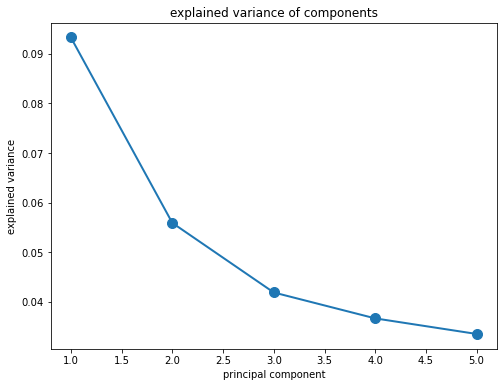

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,6), pca.explained_variance_ratio_[:5], lw=2)
ax.scatter(range(1, 6), pca.explained_variance_ratio_[:5], s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

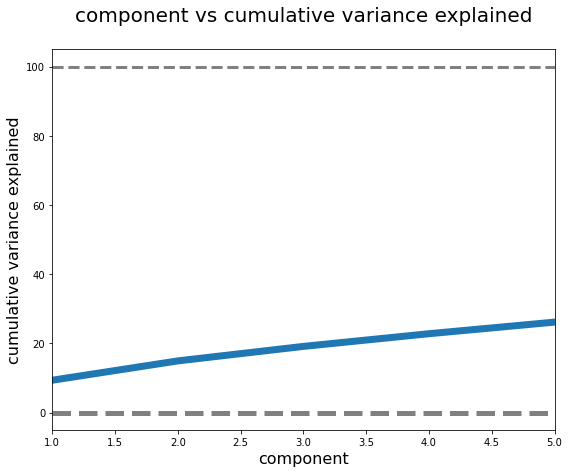

In [31]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(9,7))
component_number = range(1, 6)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,5])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [32]:
pca_df = pd.DataFrame(pca.transform(X_train_feat_removed),
                      columns=['pc_' + str(i) for i in range(5)])
pca_df.head()

,pc_0,pc_1,pc_2,pc_3,pc_4
0,-3.588060,0.824728,-0.679685,0.474095,0.167996
1,-0.824797,1.982285,-2.148299,-1.153151,-1.034176
2,-2.223797,0.875356,0.854042,0.821795,-0.630844
3,1.249783,1.850788,-1.895917,0.348153,0.101185
4,2.590999,0.573798,1.851709,2.013579,-1.007802


In [33]:
noise = pca_df.iloc[:,:5]

X_train_feat_select.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train_final = pd.concat([X_train_feat_select,noise],axis=1)
X_train_final.head()

,cause_recoded_ord,sci_consensus_ord,harm_personally_ord,harm_US_ord,harm_dev_countries_ord,harm_future_gen_ord,harm_plants_animals_ord,when_harm_US_ord,educ_category_ord,reg_CO2_pollutant_ord,...,party_x_ideo_Moderate/Conservative Democrat,party_x_ideo_No Party/Not Interested in politics,marit_status_Married,house_type_One-family house detached from any other house,service_attendance,pc_0,pc_1,pc_2,pc_3,pc_4
0,0.292816,0.259868,-1.614592,-2.066117,-2.140827,0.520317,-0.255009,-0.244346,1.131387,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,-0.623885,-3.588060,0.824728,-0.679685,0.474095,0.167996
1,0.292816,0.952731,0.713492,0.580237,0.579083,0.520317,0.511569,-0.244346,1.131387,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,1.065607,-0.824797,1.982285,-2.148299,-1.153151,-1.034176
2,0.292816,-0.263157,-1.614592,0.580237,0.579083,0.520317,0.511569,-0.244346,-0.947208,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,-1.187049,-2.223797,0.875356,0.854042,0.821795,-0.630844
3,0.292816,-0.263157,0.713492,0.580237,0.579083,0.520317,0.511569,-0.244346,0.092090,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,1.628771,1.249783,1.850788,-1.895917,0.348153,0.101185
4,0.292816,0.952731,0.713492,0.580237,0.579083,0.520317,0.511569,-0.244346,-0.947208,0.592776,...,-0.510733,-0.348963,-1.185328,0.620038,-0.623885,2.590999,0.573798,1.851709,2.013579,-1.007802


In [34]:
pca_df_test = pd.DataFrame(pca.transform(X_test_feat_removed),
                      columns=['pc_' + str(i) for i in range(5)])
pca_df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4
0,0.469957,0.614849,-2.197415,-2.695060,0.406789
1,0.356862,1.197049,0.084433,0.220224,-0.309673
2,1.011859,-0.504181,0.578666,1.085812,1.210270
3,2.148055,-2.865227,1.815318,0.791613,1.938985
4,1.820066,4.182518,0.941523,2.228815,0.730989


In [35]:
pca.transform(X_test_feat_removed)

X_test_feat_select.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test_final = pd.concat([X_test_feat_select,pca_df_test.iloc[:,:5]],axis=1)
X_test_final.head()

,cause_recoded_ord,sci_consensus_ord,harm_personally_ord,harm_US_ord,harm_dev_countries_ord,harm_future_gen_ord,harm_plants_animals_ord,when_harm_US_ord,educ_category_ord,reg_CO2_pollutant_ord,...,party_x_ideo_Moderate/Conservative Democrat,party_x_ideo_No Party/Not Interested in politics,marit_status_Married,house_type_One-family house detached from any other house,service_attendance,pc_0,pc_1,pc_2,pc_3,pc_4
0,0.292816,0.952731,0.713492,0.580237,0.579083,0.520317,0.511569,1.180543,1.131387,0.537854,...,-0.510733,-0.348963,-1.185328,0.620038,-0.623885,0.469957,0.614849,-2.197415,-2.695060,0.406789
1,0.292816,-0.263157,0.713492,0.580237,0.579083,0.520317,0.511569,1.180543,0.092090,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,1.065607,0.356862,1.197049,0.084433,0.220224,-0.309673
2,0.292816,-0.263157,0.713492,0.580237,0.579083,0.520317,0.511569,-0.244346,-0.947208,0.592776,...,1.957971,-0.348963,-1.185328,0.620038,1.065607,1.011859,-0.504181,0.578666,1.085812,1.210270
3,0.292816,0.952731,0.713492,0.580237,0.579083,0.520317,0.511569,-0.244346,0.092090,0.592776,...,-0.510733,2.865636,-1.185328,-1.612805,-0.060721,2.148055,-2.865227,1.815318,0.791613,1.938985
4,0.292816,0.952731,0.713492,0.580237,-0.780872,0.520317,0.511569,-0.244346,-0.947208,0.592776,...,-0.510733,-0.348963,0.843649,0.620038,1.628771,1.820066,4.182518,0.941523,2.228815,0.730989


## Exports

In [36]:
y_train.to_csv('../data/y_train_processed.csv', index=False)
y_test.to_csv('../data/y_test_processed.csv', index=False)

X_train_final.to_csv('../data/x_train_ss_processed.csv', index=False)
X_test_final.to_csv('../data/x_test_ss_processed.csv', index=False)